In [2]:
%load_ext autoreload
import numpy as np
import pathlib
import matplotlib.pyplot as plt

from msl_data import MSLData
from image_utils import *
from prompt_planner import *

# Note, Torch Resize is not 100% consistent in assigning labels
%autoreload 2
%matplotlib inline

plt.rc('font', size=20)
plt.rc('font', family='Times New Roman')
# plt.rc('fontname', "Times New Roman")
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'large'

In [3]:
DATA_DIR = pathlib.Path("data/ai4mars-dataset-merged-0.3/msl")
dataset = MSLData(DATA_DIR)
print(len(dataset))

18127


<Axes: >

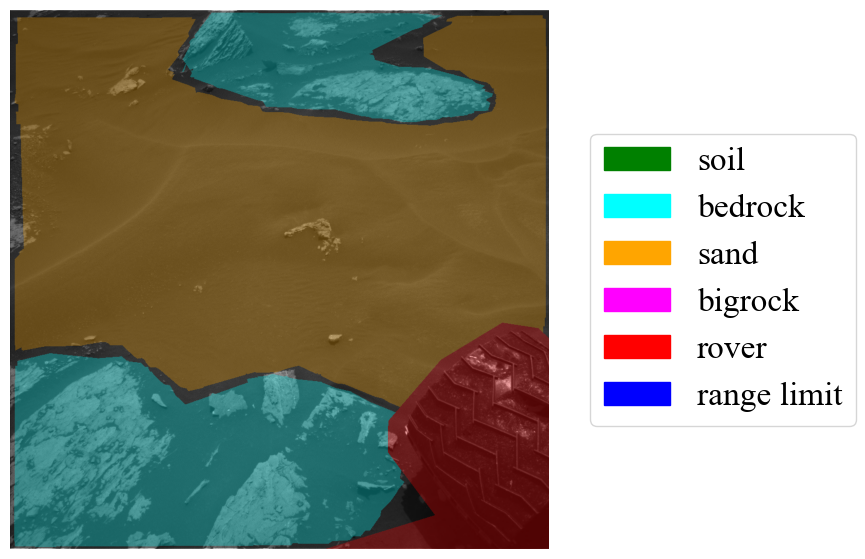

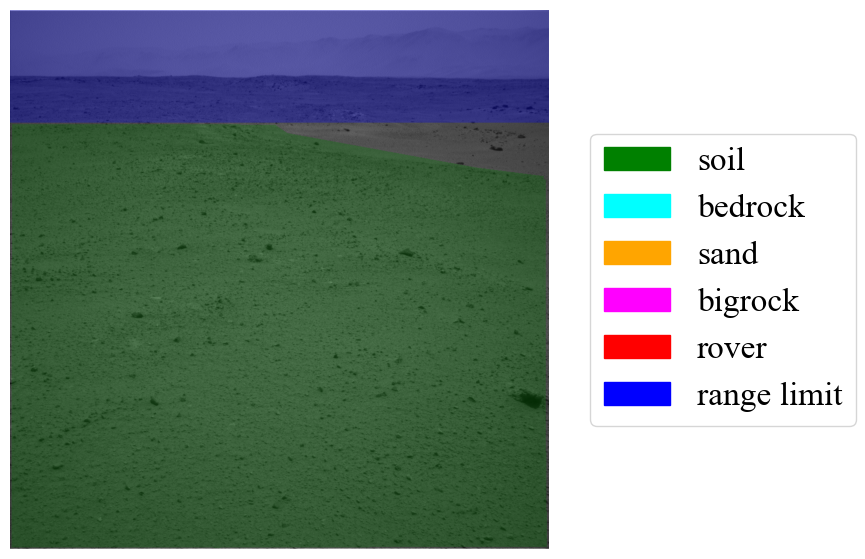

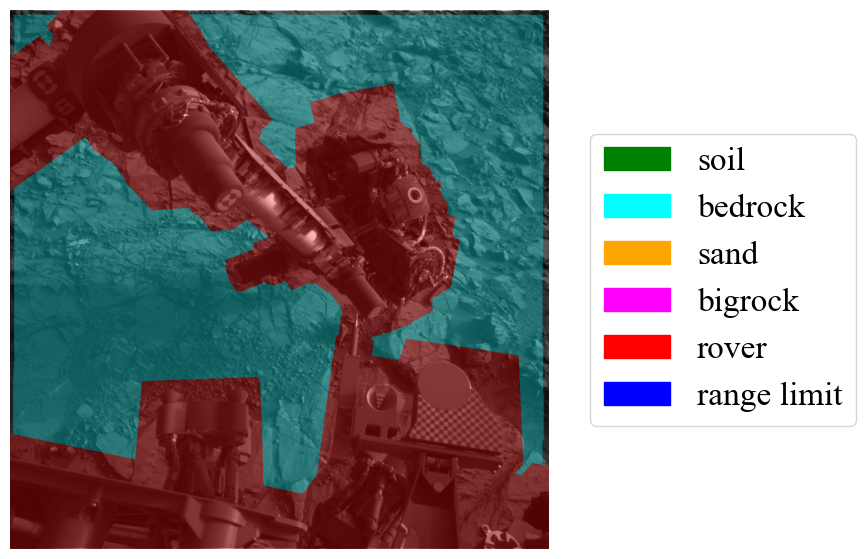

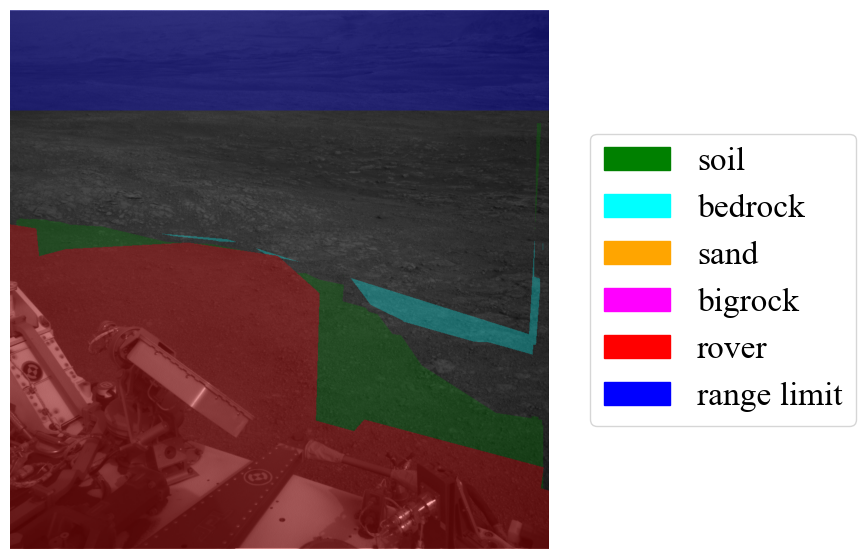

In [3]:
dataset.plot_sample(2000) # test if untraverseable areas get detected as untraversible
dataset.plot_sample(1000) # test if horizon gets excluded from drivable area
dataset.plot_sample(8000) # test if images with major rover occlusions get excluded
dataset.plot_sample(7500) # test if start region gets moved if rover is blocking the bottom row # test if unlabeled regions get selected as free space

## Grid the images and cluster by type

In [4]:
image, rover_mask, range_mask, label, raw_label, image_id = dataset[2000]

In [5]:
grid_image = GridImage(image, rover_mask, range_mask, label, dataset.class_labels)

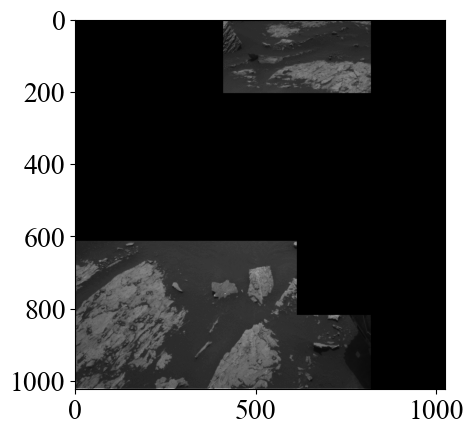

In [6]:
mask = grid_image.get_obstacle_grid(["sand"])
masked_image = grid_image.apply_mask(mask)
plt.imshow(masked_image, cmap="gray")

## Setup the planner

In [7]:
#config
gridsize = (5,5)
row_labels = ["top", "upper", "center", "lower", "bottom"]
column_labels = ["far left", "left", "center", "right", "far right"]
cardinal_directions = ["forward", "to the right", "backward", "to the left"]
class_aliasses = {
    "soil": "soil",
    "bedrock": "bedrock",
    "sand": "sand",
    "bigrock": "big rocks"
}

planner = Planner(gridsize, row_labels, column_labels, cardinal_directions, class_aliasses)

[(4, 2), (3, 2), (3, 1), (3, 0)]


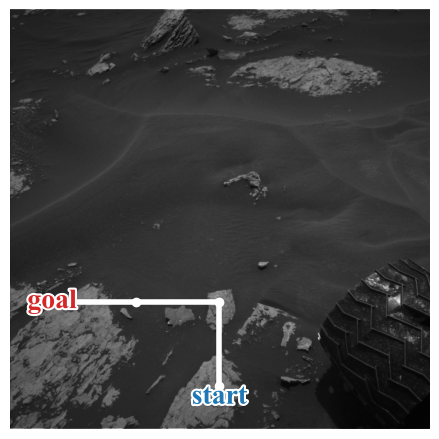

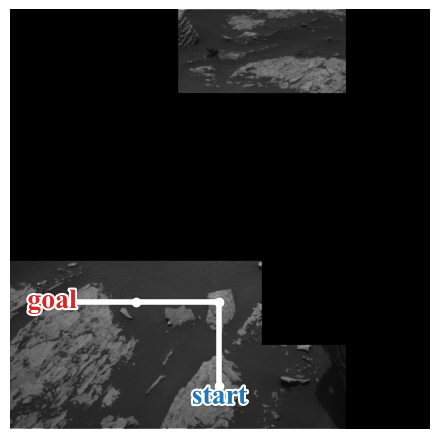

In [8]:
output = planner.generate_search_prompt(
    grid_image, 
    planner.start_coordinate, 
    (3,0), 
    ["sand"],
    source_dir=dataset.image_dir,
    save_dir=pathlib.Path("data/planning"),
    image_id=image_id
)

In [9]:
import json
with open('test_feasible.json', 'w', encoding='utf-8') as f:
    json.dump(output, f, ensure_ascii=False, indent=4)

[]


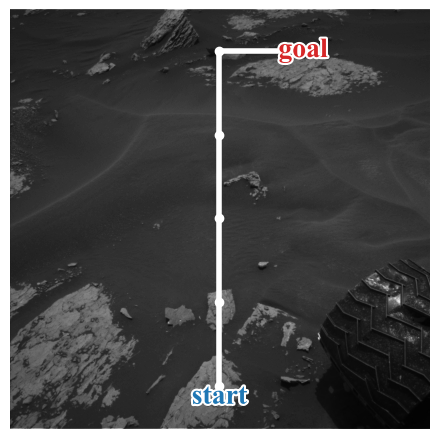

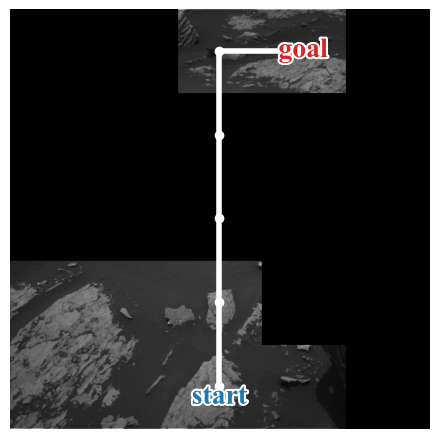

In [10]:
output = planner.generate_search_prompt(
    grid_image, 
    planner.start_coordinate, 
    (0,3), 
    ["sand", "bigrock"],
    source_dir=dataset.image_dir,
    save_dir=pathlib.Path("data/planning"),
    image_id=image_id
)

In [11]:
import json
with open('test_infeasible.json', 'w', encoding='utf-8') as f:
    json.dump(output, f, ensure_ascii=False, indent=4)

## Horizon cannot be goal region

In [12]:
image, rover_mask, range_mask, label, raw_label, image_id = dataset[1000]
grid_image = GridImage(image, rover_mask, range_mask, label, dataset.class_labels)

[0 0 0 0 0]


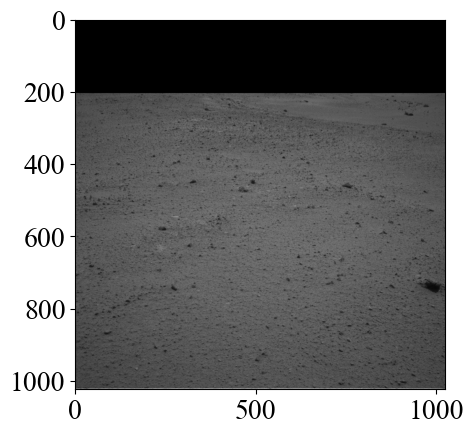

In [13]:
mask = grid_image.get_obstacle_grid([])
masked_image = grid_image.apply_mask(mask)
plt.imshow(masked_image, cmap="gray")
print(mask[0,:])

In [14]:
def is_valid_goal(goal, mask):
    return mask[goal] == 1

In [15]:
print(is_valid_goal((0,2), mask))
print(is_valid_goal((2,2), mask))

False
True


## Test if images with major occlusions get excluded

In [16]:
def major_occlusions(mask):
    majority_rover_check = np.sum(mask) < .25 * np.prod(mask.shape)
    rover_in_top = np.any(np.sum(mask == 0, axis=1)[1:3])
    return majority_rover_check or rover_in_top

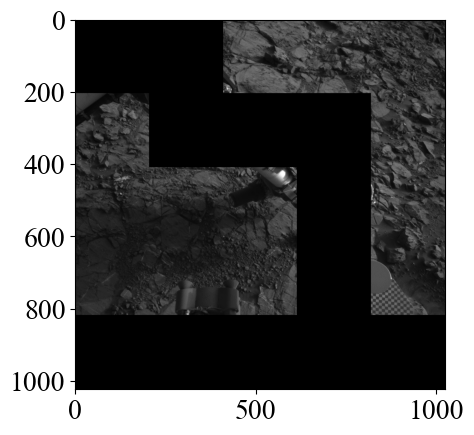

In [17]:
image, rover_mask, range_mask, label, raw_label, image_id = dataset[8000]
grid_image = GridImage(image, rover_mask, range_mask, label, dataset.class_labels)
mask = grid_image.get_obstacle_grid([])
plt.imshow(grid_image.apply_mask(mask), cmap="gray")


In [18]:
print(major_occlusions(mask))
mask = np.ones(mask.shape)
mask[:,2] = 0
print(major_occlusions(mask))
mask = np.ones(mask.shape)
mask[2:,:] = 0
print(major_occlusions(mask))
mask = np.ones(mask.shape)
mask[3:,:] = 0
print(major_occlusions(mask))
mask = np.ones(mask.shape)
mask[0,:] = 0
print(major_occlusions(mask))

True
True
True
False
False


## Test if starting point gets moved when rover is blocking and unlabeled space is free by default

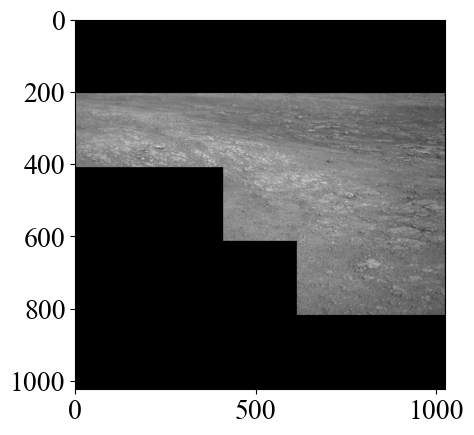

In [19]:
image, rover_mask, range_mask, label, raw_label, image_id = dataset[7500]
grid_image = GridImage(image, rover_mask, range_mask, label, dataset.class_labels)
mask = grid_image.get_obstacle_grid([])
plt.imshow(grid_image.apply_mask(mask), cmap="gray")


In [24]:
def edit_start_coord(start_coordinate, mask):
    start_coord = start_coordinate
    col_id =start_coord[1]
    return (max(np.where(mask[:,col_id] == 1)[0]), col_id)


In [26]:
start_coord = edit_start_coord(planner.start_coordinate, mask)

[(2, 2), (1, 2), (1, 3), (1, 4)]


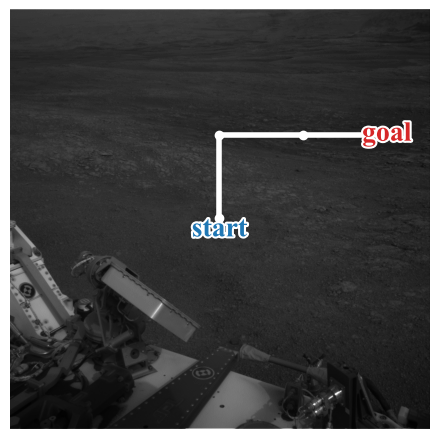

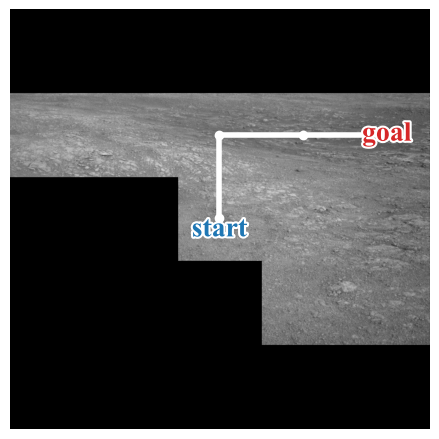

In [27]:
output = planner.generate_search_prompt(
    grid_image, 
    start_coord, 
    (1,4), 
    ["sand", "bigrock"],
    source_dir=dataset.image_dir,
    save_dir=pathlib.Path("data/planning"),
    image_id=image_id
)